In [1]:

from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt


from qutip import *
from qutip import Qobj, fidelity, ket2dm, basis, tensor


from qiskit_aer.noise import pauli_error, depolarizing_error, thermal_relaxation_error

from qiskit_aer.noise import (
    NoiseModel,
    amplitude_damping_error,
    phase_damping_error,
    pauli_error,
    depolarizing_error
)

# MY NOISE AND FUNCTIONS
import depolarizing_noise
from depolarizing_noise import *
from depolarizing_noise import ibm_sherbrooke_params

import qutip_functions
from qutip_functions import *

from collections import Counter


In [2]:
# extract T1, T2, and p from the device (Qubit 3 wa snear average)
# Qubit 3: T1 = 3.73e-04 s, T2 = 3.36e-04 s, p = 2.31e-04
# tg = t_int = 5.33333333e-07
T1 = 3.73e-04 
T2 = 3.36e-04
p = 2.31e-04
tg = 5.33333333e-07


# worse noise
p_worse = p*100
cycles = 1


In [3]:
# Define custom entangled state
A, B, C, D = 1, 0, 0, 1

state_vector = np.array([A, B, C, D])
# Define custom entangled state
norm = np.linalg.norm(state_vector)
state_vector = state_vector / norm

# Create q1-q2 2-qubit entangled state
data_state = Qobj(state_vector, dims=[[2, 2], [1, 1]])

# q0 and q3 in |0>
zero = basis(2, 0)
psi0 = tensor(zero, data_state, zero)  # q0 ⊗ (q1,q2) ⊗ q3
psi0_flat = Qobj(psi0.full())  # Flatten to 4x1

rho_ideal = ket2dm(psi0_flat)

In [4]:
def custom_noise(T1, T2, p, tg):
    # Calculate damping probabilities from gate time
    gamma_amp = 1 - np.exp(-tg / T1)  # For amplitude damping
    gamma_phase = 1 - np.exp(-tg / T2)  # For phase damping

    # Create noisy 1-qubit gate error (depolarizing + thermal)
    dep_error = depolarizing_error(p, 1)

    # calculate amplitude dampening and phase damping noise
    amp_damp_error = amplitude_damping_error(gamma_amp)
    phase_damp_error = phase_damping_error(gamma_phase)

    # Combine errors if desired (e.g., depolarizing followed by amplitude and phase damping)
    combined_1q_error = dep_error.compose(amp_damp_error).compose(phase_damp_error)


    # Create noise model and add all errors
    noise_model = NoiseModel()

    # Add noisy reset
    noise_model.add_all_qubit_quantum_error(combined_1q_error, ['reset'])

    # Add noisy single-qubit gates
    noise_model.add_all_qubit_quantum_error(combined_1q_error, ['x', 'h', 'i'])
    
    return noise_model


def qiskit_noise_4q_surface(psi_0, T1, T2, p, tg, cycles):

    # (Optional) Add more gates or readout errors here

    qc = QuantumCircuit(4, cycles*2)
    
    norm = np.linalg.norm(psi_0)
    psi_0 = psi_0 / norm


    


    qc.initialize(psi_0, [1, 2]) 
    #qc.h(1)
    #qc.cx(1, 2)


    qc.barrier()
    for i in range(cycles):   
        # Reset q1 and q4 (qubit indices )
        qc.reset(0)
        qc.reset(3)
        
        qc.h(0)
        qc.id(1)
        qc.id(2)
        qc.id(3)
                
        # Apply CNOT gates as per the circuit diagram
        qc.cx(0, 1)  # CNOT from qubit 0 to qubit 1
        qc.cx(0, 2)  # CNOT from qubit 0 to qubit 2
        qc.cx(1, 3)  # CNOT from qubit 2 to qubit 1
        qc.cx(2, 3)  # CNOT from qubit 2 to qubit 3
        qc.barrier()
        # Apply Identity (I) on qubit 3 (corresponding to |lg>) - no explicit gate needed

        # Apply Hadamard gate on qubit 0 before measurement in the X basis
        qc.h(0)
        qc.id(1)
        qc.id(2)
        qc.id(3)

        # Measure qubits in the X and Z bases
        qc.measure(0, 2*i)  # X_a measurement
        qc.measure(3, 2*i+1)  # Z_b measurement

        

    qc.save_density_matrix()
    # Draw the circuit
    qc.draw("mpl")
    
    return qc

In [5]:
def qiskit_simulate_noisy_4q_surface(psi_0, T1, T2, p, tg, cycles, Num_shots):
    densities_qiskit = []
    custom_noise_model = custom_noise(T1, T2, p, tg)
    qc = qiskit_noise_4q_surface(psi_0, T1, T2, p, tg, cycles)
    simulator = AerSimulator(method='statevector', noise_model=custom_noise_model)
    result = simulator.run(qc, shots=Num_shots).result()
    counts = result.get_counts()

    density_out_qiskit = result.data(0)['density_matrix']
    rho_qiskit = Qobj(density_out_qiskit)
    densities_qiskit.append(rho_qiskit)
    
    return density_out_qiskit, counts

In [16]:
# Process and analyze results
def analyze_results(counts, cycles):
    x_results = {}
    z_results = {}

    for bitstring, count in counts.items():
        bitstring = bitstring[::-1]  # Reverse Qiskit bit order

        x_key = tuple(bitstring[2*i] for i in range(cycles))     # Even indices: 0,2,...
        z_key = tuple(bitstring[2*i + 1] for i in range(cycles)) # Odd indices: 1,3,...

        x_results[x_key] = x_results.get(x_key, 0) + count
        z_results[z_key] = z_results.get(z_key, 0) + count

    # Make string versions for display
    x_results_str = {','.join(key): val for key, val in x_results.items()}
    z_results_str = {','.join(key): val for key, val in z_results.items()}
    
    return x_results_str, z_results_str



import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
import numpy as np

def plot_trajectory_distribution(results_str, title, counts):
    total_shots = sum(counts.values())

    # Sort by descending probability
    sorted_items = sorted(results_str.items(), key=lambda x: x[1], reverse=True)
    trajectories = [list(map(int, key.split(','))) for key, _ in sorted_items]
    probabilities = [count / total_shots for _, count in sorted_items]

    # Colors: top in lighter red, others in blue-green (winter)
    n = len(probabilities)
    top_color = (1.0, 0.4, 0.4)  # lighter red
    cmap = cm.get_cmap('winter')
    color_values = [cmap(0.2 + 0.8 * (i / max(n - 1, 1))) for i in range(n - 1)]
    colors = color_values[:] + [top_color]

    # Reverse trajectories and probabilities to match color order
    final_trajectories = trajectories[::-1] + [trajectories[0]]
    final_probabilities = probabilities[::-1] + [probabilities[0]]

    # Plot
    fig, ax = plt.subplots(figsize=(10, 2.5))
    handles_labels = []

    for traj, prob, color in zip(final_trajectories, final_probabilities, colors):
        line, = ax.plot(
            range(1, len(traj) + 1), traj, '-o',
            color=color,
            alpha=0.7,
            linewidth=2.5 if prob > 0.01 else 1,
            label=f'{prob*100:.2f}%'
        )
        handles_labels.append((line, f'{prob*100:.2f}%'))

    # Styling
    ax.set_title(f'{title} Trajectory Distribution', fontsize=16)
    ax.set_xlabel('Cycle', fontsize=14)
    ax.set_ylabel('Measurement', fontsize=14)
    ax.set_ylim(-0.2, 1.2)
    ax.set_xticks(range(1, len(trajectories[0]) + 1))
    ax.set_yticks([0, 1])
    ax.tick_params(axis='both', labelsize=14)
    ax.grid(True)

    # Sort legend entries by descending probability (ensure red first)
    handles_labels.sort(key=lambda x: -float(x[1].split('%')[0]))
    handles, labels = zip(*handles_labels)
    ax.legend(handles, labels, title='Probabilities', bbox_to_anchor=(1.05, 1.05), loc='upper left')

    plt.tight_layout()
    plt.show()



In [7]:

def qutip_simulate_surface_code_multi_cycle(psi0_flat, p, T1, T2, tg, num_cycles=1, additional_noise=False):
    """
    Simulate a single multi-cycle trajectory using the QuTiP model.
    At each cycle, call simulate_noisy_4_qubit_surface with one shot.
    Returns a single full-length bitstring and final state.
    """
    psi = psi0_flat
    full_bitstring = ''
    
    for _ in range(num_cycles):
        counts, psi_outcomes = simulate_noisy_4_qubit_surface(
            psi, p=p, T1=T1, T2=T2, tg=tg,
            shots=1,
            plot_bool=False,
            additional_noise=additional_noise
        )
        psi = psi_outcomes[0]
        
        #print(counts)
        bitstring = [k for k, v in counts.items() if v == 1][0]

        #print("Measured bitstring:", bitstring)
        bitstring_entry = bitstring[0]+bitstring[3]
        
        #print("Measured bitstring:", bitstring_entry)
        full_bitstring+=str(bitstring_entry[::-1])

    return full_bitstring


def qutip_simulate_surface_code_multi_shots(num_shots, psi0_flat, p, T1, T2, tg, num_cycles=1, additional_noise=False):
    
    shots_bitstring = []
    
    for _ in range(num_shots):
        full_bitstring = qutip_simulate_surface_code_multi_cycle(psi0_flat, p, T1, T2, tg, num_cycles=num_cycles, additional_noise=additional_noise)
        shots_bitstring.append(full_bitstring)
    
    
    return dict(Counter(shots_bitstring))



C:\Users\npace\AppData\Local\Temp\ipykernel_20508\4289171574.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('winter')


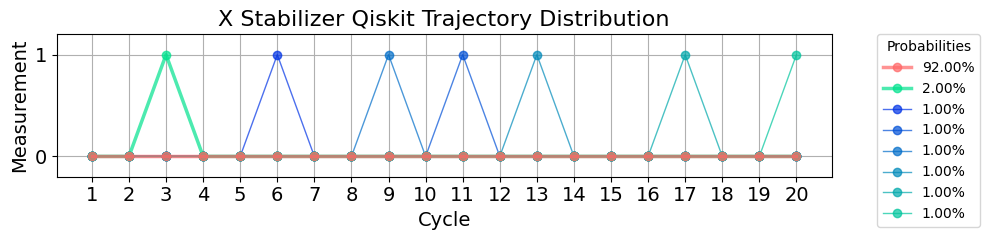

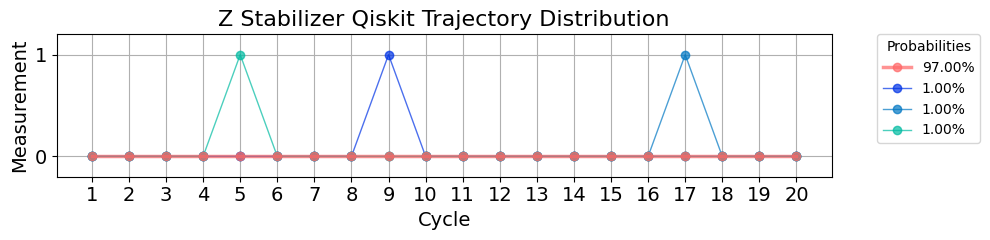

In [21]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

Num_cycles = 20
Num_shots = 100
p_sim = p*10

###################
# Qiskit Trajectory
###################
density_out_qiskit, counts_qiskit = qiskit_simulate_noisy_4q_surface(state_vector, T1, T2, p_sim, tg, Num_cycles, Num_shots)

x_results_str_qiskit, z_results_str_qiskit = analyze_results(counts_qiskit, Num_cycles)
plot_trajectory_distribution(x_results_str_qiskit, "X Stabilizer Qiskit", counts_qiskit)
plot_trajectory_distribution(z_results_str_qiskit, "Z Stabilizer Qiskit", counts_qiskit)



C:\Users\npace\AppData\Local\Temp\ipykernel_20508\4289171574.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('winter')


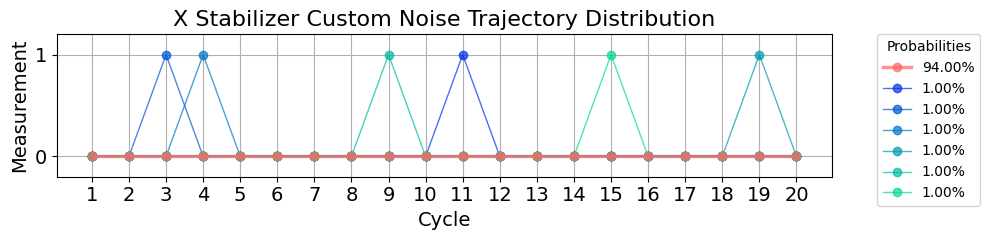

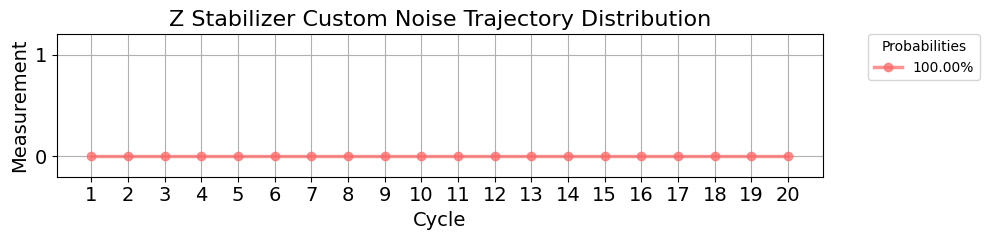

In [22]:
###################
# Qutip (Custom) Trajectory
###################
counts_qutip = qutip_simulate_surface_code_multi_shots(Num_shots, psi0_flat, p_sim, T1, T2, tg, num_cycles=Num_cycles, additional_noise=True)
x_results_str_qutip, z_results_str_qutip = analyze_results(counts_qutip, Num_cycles)
plot_trajectory_distribution(x_results_str_qutip, "X Stabilizer Custom Noise", counts_qutip)
plot_trajectory_distribution(z_results_str_qutip, "Z Stabilizer Custom Noise", counts_qutip)
